In [1]:
import numpy as np
np.random.seed(73)

In [2]:
import sys, os
# Adjusting the location of the src folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  
src_path     = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [3]:
from RQE import RQE, Player

In [4]:
# taken from https://gist.github.com/daien/1272551
# Basically Implements Corollary 6.29 First Order Optimization, Amir Beck
def project_simplex(v, s=1):
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    v = np.reshape(v, (v.shape[0]))
    n,   = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.all(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = float(cssv[rho] - s) / (rho+1)
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w

# Helper gradient functions

In [5]:
def gradient_log_barrier(x):
    # log_barrier(x) = -np.log(x)
    return -1 / x

def gradient_KL(p, q):
    # KL(p, q) = p * np.log(p / q)
    return np.log(p / q) + 1

def gradient_entropy(x):
    # entropy(x) = x * np.log(x)
    return np.log(x) + 1

def gradient_reverse_KL(p, q):
    # reverse KL: KL(q, p) = q * np.log(q / p)
    return - q / p

# Gradient of the objective function J1 and J2 with KL and log barrier
def gradient_J1(pi_1, p_1, R1, epsilon_1):
    return - R1 @ p_1 + epsilon_1 * gradient_log_barrier(pi_1)

def gradient_J_bar1(pi_1, p_1, R1, pi_2, tau_1):
    return R1.T @ pi_1 + (1/tau_1) * gradient_KL(p_1, pi_2)

def gradient_J2(pi_2, p_2, R2, epsilon_2):
    return - R2 @ p_2 + epsilon_2 * gradient_log_barrier(pi_2)

def gradient_J_bar2(pi_2, p_2, R2, pi_1, tau_2):
    return R2.T @ pi_2 + (1/tau_2) * gradient_KL(p_2, pi_1) 

# Gradient of the objective function J1 and J2 with reverse KL and entropy
def gradient_J1_rev(pi_1, p_1, R1, epsilon_1):
    return - R1 @ p_1 + epsilon_1 * gradient_entropy(pi_1)

def gradient_J_bar1_rev(pi_1, p_1, R1, pi_2, tau_1):
    return R1.T @ pi_1 + (1/tau_1) * gradient_reverse_KL(p_1, pi_2)

def gradient_J2_rev(pi_2, p_2, R2, epsilon_2):
    return - R2 @ p_2 + epsilon_2 * gradient_entropy(pi_2)

def gradient_J_bar2_rev(pi_2, p_2, R2, pi_1, tau_2):
    return R2.T @ pi_2 + (1/tau_2) * gradient_reverse_KL(p_2, pi_1)

In [6]:
# Gradient descent algorithm

def gradient_descent_ascent(R, epsilon, tau, dist='kl', learning_rate=2e-3, num_iterations=1000):

    # Initialize random players' strategies
    players = np.random.rand(4, 2)
    players /= np.sum(players, axis=1, keepdims=True)
    #players[0] = policies[0]
    #players[1] = risk_policeis[0]
    #players[2] = policies[1]
    #players[3] = risk_policies[1]

    for _ in range(num_iterations):
        # Calculate gradients
        gradients = np.zeros_like(players)
        if dist == 'kl':
            gradients[0] = gradient_J1(players[0], players[1], R[0], epsilon[0])
            gradients[1] = gradient_J_bar1(players[0], players[1], R[0], players[2], tau[0])
            gradients[2] = gradient_J2(players[2], players[3], R[1], epsilon[1]) # analise terminou aq
            gradients[3] = gradient_J_bar2(players[2], players[3], R[1], players[0], tau[1])
        elif dist == 'reverse_kl':
            gradients[0] = gradient_J1_rev(players[0], players[1], R[0], epsilon[0])
            gradients[1] = gradient_J_bar1_rev(players[0], players[1], R[0], players[2], tau[0])
            gradients[2] = gradient_J2_rev(players[2], players[3], R[1], epsilon[1])
            gradients[3] = gradient_J_bar2_rev(players[2], players[3], R[1], players[0], tau[1])

        
        players -= learning_rate * gradients  

        # Ensure strategies are within valid range
        players = np.clip(players, 1e-8, 1-1e-8)  # Avoid division by zero in log and kl_div

        # Project back to probability distribution
        for i in range(4):
            players[i] = project_simplex(players[i])

    return players

# Risk aversion is important Matching Penny setup

In [7]:

# Risk aversion Game 4
# Initialize payoff matrices from matching pennies example
R1 = np.array([[200, 160], [370, 10]])
R2 = np.array([[160, 10], [200, 370]])
R = [R1, R2.T]

# Expected pi_1 and pi_2 players' strategies
expected_pi1_pi2_players = np.array([[0.47, 0.53],[0.65, 0.35]])

# Initialize hyperparameters
epsilon = np.array([170, 110]) 
tau = np.array([0.001, 0.06])

players = [
    Player(tau=tau[0], epsilon=epsilon[0], game_matrix=R1),
    Player(tau=tau[1], epsilon=epsilon[1], game_matrix=R2.T),
]
rqe_solver = RQE(players=players, lr=2e-4, max_iter=10000, br_iters=50)
print("Our pi_1 pi_2 stratagies", rqe_solver.optimize())

# Run the gradient descent/ascent algorithm
final_players = gradient_descent_ascent(R, epsilon, tau, learning_rate=1e-4)

print("Expected pi_1 pi_2 strategies:")
print(expected_pi1_pi2_players)
print("pi_1 pi_2 strategies:")
print(final_players[0:4:2,:])
print("(eps2.tau2)>(1/eps1.tau1):", epsilon[1]*tau[1] , 1/(epsilon[0]*tau[0]))

Our pi_1 pi_2 stratagies [[0.46981368 0.53018632]
 [0.64674576 0.35325424]]
Expected pi_1 pi_2 strategies:
[[0.47 0.53]
 [0.65 0.35]]
pi_1 pi_2 strategies:
[[0.46891109 0.53108891]
 [0.65049403 0.34950597]]
(eps2.tau2)>(1/eps1.tau1): 6.6 5.88235294117647


# Game 1 - 12 : Selten, Reinhard; Chmura, Thorsten

In [8]:

# Game 1
# Initialize payoff matrices from matching pennies example
R1 = np.array([[10, 0], [9, 10]])
R2 = np.array([[10, 18], [9, 8]])
R = [R1, R2.T]

# Expected pi_1 and pi_2 players' strategies
expected_pi1u_pi2l = np.array([[0.079, 0.921],[0.69, 0.31]])

# Initialize hyperparameters
epsilon = np.array([0.21, 0.555]) 
tau = np.array([0.1, 100])

players = [
    Player(tau=tau[0], epsilon=epsilon[0], game_matrix=R1),
    Player(tau=tau[1], epsilon=epsilon[1], game_matrix=R2.T),
]
rqe_solver = RQE(players=players, lr=2e-4, max_iter=10000, br_iters=50)
print("Our pi_1 pi_2 stratagies", rqe_solver.optimize())

# Run the gradient descent/ascent algorithm
final_players = gradient_descent_ascent(R, epsilon, tau, learning_rate=2e-4, num_iterations=10000)

print("Expected pi_1 pi_2 strategies:")
print(expected_pi1u_pi2l)
print("pi_1 pi_2 strategies:")
print(final_players[0:4:2,:])
print("(eps2.tau2)>(1/eps1.tau1):", epsilon[1]*tau[1] , 1/(epsilon[0]*tau[0]))

Our pi_1 pi_2 stratagies [[0.08039729 0.91960271]
 [0.68987642 0.31012358]]
Expected pi_1 pi_2 strategies:
[[0.079 0.921]
 [0.69  0.31 ]]
pi_1 pi_2 strategies:
[[0.07995499 0.92004501]
 [0.68887577 0.31112423]]
(eps2.tau2)>(1/eps1.tau1): 55.50000000000001 47.61904761904761


In [9]:

# Game 2
# Initialize payoff matrices from matching pennies example
R1 = np.array([[9, 0], [6, 8]])
R2 = np.array([[4, 13], [7, 5]])
R = [R1, R2.T]

# Expected pi_1 and pi_2 players' strategies
expected_pi1u_pi2l = np.array([[0.217, 0.783],[0.527, 0.473]])

# Initialize hyperparameters
epsilon = np.array([0.68, 10]) 
tau = np.array([0.08, 2])

players = [
    Player(tau=tau[0], epsilon=epsilon[0], game_matrix=R1),
    Player(tau=tau[1], epsilon=epsilon[1], game_matrix=R2.T),
]
rqe_solver = RQE(players=players, lr=2e-4, max_iter=10000, br_iters=50)
print("Our pi_1 pi_2 stratagies", rqe_solver.optimize())

# Run the gradient descent/ascent algorithm
final_players = gradient_descent_ascent(R, epsilon, tau, learning_rate=2e-4, num_iterations=10000)

print("Expected pi_1 pi_2 strategies:")
print(expected_pi1u_pi2l)
print("pi_1 pi_2 strategies:")
print(final_players[0:4:2,:])
print("(eps2.tau2)>(1/eps1.tau1):", epsilon[1]*tau[1] , 1/(epsilon[0]*tau[0]))

Our pi_1 pi_2 stratagies [[0.21423378 0.78576622]
 [0.52450922 0.47549078]]
Expected pi_1 pi_2 strategies:
[[0.217 0.783]
 [0.527 0.473]]
pi_1 pi_2 strategies:
[[0.21423378 0.78576622]
 [0.52450922 0.47549078]]
(eps2.tau2)>(1/eps1.tau1): 20.0 18.38235294117647


In [10]:


# Game 3
# Initialize payoff matrices from matching pennies example
R1 = np.array([[8, 0], [7, 10]])
R2 = np.array([[6, 14], [7, 4]])
R = [R1, R2.T]

# Expected pi_1 and pi_2 players' strategies
expected_pi1u_pi2l = np.array([[0.163],[0.793]])

# Initialize hyperparame5ers
epsilon = np.array([0.216, 0.837]) 
tau = np.array([0.1, 56])

players = [
    Player(tau=tau[0], epsilon=epsilon[0], game_matrix=R1),
    Player(tau=tau[1], epsilon=epsilon[1], game_matrix=R2.T),
]
rqe_solver = RQE(players=players, lr=2e-4, max_iter=10000, br_iters=50)
print("Our pi_1 pi_2 stratagies", rqe_solver.optimize())

# Run the gradient descent/ascent algorithm
final_players = gradient_descent_ascent(R, epsilon, tau, learning_rate=2e-4, num_iterations=10000)

print("Expected pi_1 pi_2 strategies:")
print(expected_pi1u_pi2l)
print("pi_1 pi_2 strategies:")
print(final_players[0:4:2,:])
print("(eps2.tau2)>(1/eps1.tau1):", epsilon[1]*tau[1] , 1/(epsilon[0]*tau[0]))



Our pi_1 pi_2 stratagies [[0.16291841 0.83708159]
 [0.79290064 0.20709936]]
Expected pi_1 pi_2 strategies:
[[0.163]
 [0.793]]
pi_1 pi_2 strategies:
[[0.16287823 0.83712177]
 [0.79290062 0.20709938]]
(eps2.tau2)>(1/eps1.tau1): 46.872 46.29629629629629


In [11]:


# Game 4
# Initialize payoff matrices from matching pennies example
R1 = np.array([[7, 0], [5, 9]])
R2 = np.array([[4, 11], [6, 2]])
R = [R1, R2.T]

# Expected pi_1 and pi_2 players' strategies
expected_pi1u_pi2l = np.array([[0.286],[0.736]])

# Initialize hyperparame5ers
epsilon = np.array([0.35, 1.64]) 
tau = np.array([0.1, 30])

players = [
    Player(tau=tau[0], epsilon=epsilon[0], game_matrix=R1),
    Player(tau=tau[1], epsilon=epsilon[1], game_matrix=R2.T),
]
rqe_solver = RQE(players=players, lr=2e-4, max_iter=10000, br_iters=50)
print("Our pi_1 pi_2 stratagies", rqe_solver.optimize())

# Run the gradient descent/ascent algorithm
final_players = gradient_descent_ascent(R, epsilon, tau, learning_rate=2e-4, num_iterations=10000)

print("Expected pi_1 pi_2 strategies:")
print(expected_pi1u_pi2l)
print("pi_1 pi_2 strategies:")
print(final_players[0:4:2,:])
print("(eps2.tau2)>(1/eps1.tau1):", epsilon[1]*tau[1] , 1/(epsilon[0]*tau[0]))



Our pi_1 pi_2 stratagies [[0.2872707  0.7127293 ]
 [0.73619428 0.26380572]]
Expected pi_1 pi_2 strategies:
[[0.286]
 [0.736]]
pi_1 pi_2 strategies:
[[0.28704582 0.71295418]
 [0.73619428 0.26380572]]
(eps2.tau2)>(1/eps1.tau1): 49.199999999999996 28.571428571428573


In [12]:


# Game 5
# Initialize payoff matrices from matching pennies example
R1 = np.array([[7, 0], [4, 8]])
R2 = np.array([[2, 9], [5, 1]])
R = [R1, R2.T]

# Expected pi_1 and pi_2 players' strategies
expected_pi1u_pi2l = np.array([[0.327],[0.664]])

# Initialize hyperparame5ers
epsilon = np.array([0.38, 2.7]) 
tau = np.array([0.1, 10])

players = [
    Player(tau=tau[0], epsilon=epsilon[0], game_matrix=R1),
    Player(tau=tau[1], epsilon=epsilon[1], game_matrix=R2.T),
]
rqe_solver = RQE(players=players, lr=2e-4, max_iter=10000, br_iters=50)
print("Our pi_1 pi_2 stratagies", rqe_solver.optimize())

# Run the gradient descent/ascent algorithm
final_players = gradient_descent_ascent(R, epsilon, tau, learning_rate=2e-4, num_iterations=10000)

print("Expected pi_1 pi_2 strategies:")
print(expected_pi1u_pi2l)
print("pi_1 pi_2 strategies:")
print(final_players[0:4:2,:])
print("(eps2.tau2)>(1/eps1.tau1):", epsilon[1]*tau[1] , 1/(epsilon[0]*tau[0]))



Our pi_1 pi_2 stratagies [[0.32786197 0.67213803]
 [0.66473769 0.33526231]]
Expected pi_1 pi_2 strategies:
[[0.327]
 [0.664]]
pi_1 pi_2 strategies:
[[0.32790741 0.67209259]
 [0.66473769 0.33526231]]
(eps2.tau2)>(1/eps1.tau1): 27.0 26.315789473684205


In [13]:


# Game 6
# Initialize payoff matrices from matching pennies example
R1 = np.array([[7, 1], [3, 8]])
R2 = np.array([[1, 7], [5, 0]])
R = [R1, R2.T]

# Expected pi_1 and pi_2 players' strategies
expected_pi1u_pi2l = np.array([[0.445],[0.596]])

# Initialize hyperparame5ers
epsilon = np.array([0.92, 3.8]) 
tau = np.array([0.1, 6])

players = [
    Player(tau=tau[0], epsilon=epsilon[0], game_matrix=R1),
    Player(tau=tau[1], epsilon=epsilon[1], game_matrix=R2.T),
]
rqe_solver = RQE(players=players, lr=2e-4, max_iter=10000, br_iters=50)
print("Our pi_1 pi_2 stratagies", rqe_solver.optimize())

# Run the gradient descent/ascent algorithm
final_players = gradient_descent_ascent(R, epsilon, tau, learning_rate=2e-4, num_iterations=10000)

print("Expected pi_1 pi_2 strategies:")
print(expected_pi1u_pi2l)
print("pi_1 pi_2 strategies:")
print(final_players[0:4:2,:])
print("(eps2.tau2)>(1/eps1.tau1):", epsilon[1]*tau[1] , 1/(epsilon[0]*tau[0]))



Our pi_1 pi_2 stratagies [[0.45865178 0.54134822]
 [0.61014102 0.38985898]]
Expected pi_1 pi_2 strategies:
[[0.445]
 [0.596]]
pi_1 pi_2 strategies:
[[0.45833964 0.54166036]
 [0.61003046 0.38996954]]
(eps2.tau2)>(1/eps1.tau1): 22.799999999999997 10.869565217391303


In [14]:


# Game 7
# Initialize payoff matrices from matching pennies example
R1 = np.array([[10, 4], [9, 14]])
R2 = np.array([[12, 22], [9, 8]])
R = [R1, R2.T]



# Expected pi_1 and pi_2 players' strategies
expected_pi1u_pi2l = np.array([[0.141],[0.564]])

# Initialize hyperparame5ers
epsilon = np.array([0.49, 1.88]) 
tau = np.array([0.1, 11])

players = [
    Player(tau=tau[0], epsilon=epsilon[0], game_matrix=R1),
    Player(tau=tau[1], epsilon=epsilon[1], game_matrix=R2.T),
]
rqe_solver = RQE(players=players, lr=2e-4, max_iter=10000, br_iters=50)
print("Our pi_1 pi_2 stratagies", rqe_solver.optimize())

# Run the gradient descent/ascent algorithm
final_players = gradient_descent_ascent(R, epsilon, tau, learning_rate=2e-4, num_iterations=10000)



print("Expected pi_1 pi_2 strategies:")
print(expected_pi1u_pi2l)
print("pi_1 pi_2 strategies:")
print(final_players[0:4:2,:])
print("(eps2.tau2)>(1/eps1.tau1):", epsilon[1]*tau[1] , 1/(epsilon[0]*tau[0]))



Our pi_1 pi_2 stratagies [[0.1415106  0.8584894 ]
 [0.56414771 0.43585229]]
Expected pi_1 pi_2 strategies:
[[0.141]
 [0.564]]
pi_1 pi_2 strategies:
[[0.14151062 0.85848938]
 [0.56414772 0.43585228]]
(eps2.tau2)>(1/eps1.tau1): 20.68 20.408163265306122


In [15]:


# Game 8
# Initialize payoff matrices from matching pennies example
R1 = np.array([[9, 3], [6, 11]])
R2 = np.array([[7, 16], [7, 5]])
R = [R1, R2.T]

# Expected pi_1 and pi_2 players' strategies
expected_pi1u_pi2l = np.array([[0.25],[0.586]])

# Initialize hyperparame5ers
epsilon = np.array([0.36, 2.8]) 
tau = np.array([0.1, 10])

players = [
    Player(tau=tau[0], epsilon=epsilon[0], game_matrix=R1),
    Player(tau=tau[1], epsilon=epsilon[1], game_matrix=R2.T),
]
rqe_solver = RQE(players=players, lr=2e-4, max_iter=10000, br_iters=50)
print("Our pi_1 pi_2 stratagies", rqe_solver.optimize())

# Run the gradient descent/ascent algorithm
final_players = gradient_descent_ascent(R, epsilon, tau, learning_rate=2e-4, num_iterations=10000)

print("Expected pi_1 pi_2 strategies:")
print(expected_pi1u_pi2l)
print("pi_1 pi_2 strategies:")
print(final_players[0:4:2,:])
print("(eps2.tau2)>(1/eps1.tau1):", epsilon[1]*tau[1] , 1/(epsilon[0]*tau[0]))



Our pi_1 pi_2 stratagies [[0.24926116 0.75073884]
 [0.58604126 0.41395874]]
Expected pi_1 pi_2 strategies:
[[0.25 ]
 [0.586]]
pi_1 pi_2 strategies:
[[0.24923748 0.75076252]
 [0.58604126 0.41395874]]
(eps2.tau2)>(1/eps1.tau1): 28.0 27.77777777777778


In [16]:


# Game 9
# Initialize payoff matrices from matching pennies example
R1 = np.array([[8, 3], [7, 13]])
R2 = np.array([[9, 17], [7, 4]])
R = [R1, R2.T]

# Expected pi_1 and pi_2 players' strategies
expected_pi1u_pi2l = np.array([[0.254],[0.827]])

# Initialize hyperparame5ers
epsilon = np.array([0.179, 0.65]) 
tau = np.array([0.1, 90])

players = [
    Player(tau=tau[0], epsilon=epsilon[0], game_matrix=R1),
    Player(tau=tau[1], epsilon=epsilon[1], game_matrix=R2.T),
]
rqe_solver = RQE(players=players, lr=2e-4, max_iter=10000, br_iters=50)
print("Our pi_1 pi_2 stratagies", rqe_solver.optimize())

# Run the gradient descent/ascent algorithm
final_players = gradient_descent_ascent(R, epsilon, tau, learning_rate=2e-4, num_iterations=10000)

print("Expected pi_1 pi_2 strategies:")
print(expected_pi1u_pi2l)
print("pi_1 pi_2 strategies:")
print(final_players[0:4:2,:])
print("(eps2.tau2)>(1/eps1.tau1):", epsilon[1]*tau[1] , 1/(epsilon[0]*tau[0]))



Our pi_1 pi_2 stratagies [[0.2598712  0.7401288 ]
 [0.82763539 0.17236461]]
Expected pi_1 pi_2 strategies:
[[0.254]
 [0.827]]
pi_1 pi_2 strategies:
[[0.25787316 0.74212684]
 [0.82763539 0.17236461]]
(eps2.tau2)>(1/eps1.tau1): 58.5 55.865921787709496


In [17]:


# Game 10
# Initialize payoff matrices from matching pennies example
R1 = np.array([[7, 2], [5, 11]])
R2 = np.array([[6, 13], [6, 2]])
R = [R1, R2.T]

# Expected pi_1 and pi_2 players' strategies
expected_pi1u_pi2l = np.array([[0.366],[0.699]])

# Initialize hyperparame5ers
epsilon = np.array([0.1, 2.11]) 
tau = np.array([0.3, 20])

players = [
    Player(tau=tau[0], epsilon=epsilon[0], game_matrix=R1),
    Player(tau=tau[1], epsilon=epsilon[1], game_matrix=R2.T),
]
rqe_solver = RQE(players=players, lr=2e-4, max_iter=10000, br_iters=50)
print("Our pi_1 pi_2 stratagies", rqe_solver.optimize())

# Run the gradient descent/ascent algorithm
final_players = gradient_descent_ascent(R, epsilon, tau, learning_rate=2e-4, num_iterations=10000)

print("Expected pi_1 pi_2 strategies:")
print(expected_pi1u_pi2l)
print("pi_1 pi_2 strategies:")
print(final_players[0:4:2,:])
print("(eps2.tau2)>(1/eps1.tau1):", epsilon[1]*tau[1] , 1/(epsilon[0]*tau[0]))



Our pi_1 pi_2 stratagies [[0.36583348 0.63416652]
 [0.69892467 0.30107533]]
Expected pi_1 pi_2 strategies:
[[0.366]
 [0.699]]
pi_1 pi_2 strategies:
[[0.36582803 0.63417197]
 [0.69892466 0.30107534]]
(eps2.tau2)>(1/eps1.tau1): 42.199999999999996 33.333333333333336


In [18]:


# Game 11
# Initialize payoff matrices from matching pennies example
R1 = np.array([[7, 2], [4, 10]])
R2 = np.array([[4, 11], [5, 1]])
R = [R1, R2.T]

# Expected pi_1 and pi_2 players' strategies
expected_pi1u_pi2l = np.array([[0.331],[0.652]])

# Initialize hyperparame5ers
epsilon = np.array([0.172, 2.97]) 
tau = np.array([0.1, 25])

players = [
    Player(tau=tau[0], epsilon=epsilon[0], game_matrix=R1),
    Player(tau=tau[1], epsilon=epsilon[1], game_matrix=R2.T),
]
rqe_solver = RQE(players=players, lr=2e-4, max_iter=10000, br_iters=50)
print("Our pi_1 pi_2 stratagies", rqe_solver.optimize())

# Run the gradient descent/ascent algorithm
final_players = gradient_descent_ascent(R, epsilon, tau, learning_rate=2e-4, num_iterations=10000)

print("Expected pi_1 pi_2 strategies:")
print(expected_pi1u_pi2l)
print("pi_1 pi_2 strategies:")
print(final_players[0:4:2,:])
print("(eps2.tau2)>(1/eps1.tau1):", epsilon[1]*tau[1] , 1/(epsilon[0]*tau[0]))



Our pi_1 pi_2 stratagies [[0.32941259 0.67058741]
 [0.65240171 0.34759829]]
Expected pi_1 pi_2 strategies:
[[0.331]
 [0.652]]
pi_1 pi_2 strategies:
[[0.32833092 0.67166908]
 [0.65240171 0.34759829]]
(eps2.tau2)>(1/eps1.tau1): 74.25 58.13953488372093


In [19]:


# Game 12
# Initialize payoff matrices from matching pennies example
R1 = np.array([[7, 3], [3, 10]])
R2 = np.array([[3, 9], [5, 0]])
R = [R1, R2.T]

# Expected pi_1 and pi_2 players' strategies
expected_pi1u_pi2l = np.array([[0.439],[0.604]])

# Initialize hyperparame5ers
epsilon = np.array([0.23, 5.74]) 
tau = np.array([0.04, 19])

players = [
    Player(tau=tau[0], epsilon=epsilon[0], game_matrix=R1),
    Player(tau=tau[1], epsilon=epsilon[1], game_matrix=R2.T),
]
rqe_solver = RQE(players=players, lr=2e-4, max_iter=10000, br_iters=50)
print("Our pi_1 pi_2 stratagies", rqe_solver.optimize())

# Run the gradient descent/ascent algorithm
final_players = gradient_descent_ascent(R, epsilon, tau, learning_rate=2e-4, num_iterations=10000)

print("Expected pi_1 pi_2 strategies:")
print(expected_pi1u_pi2l)
print("pi_1 pi_2 strategies:")
print(final_players[0:4:2,:])
print("(eps2.tau2)>(1/eps1.tau1):", epsilon[1]*tau[1] , 1/(epsilon[0]*tau[0]))

Our pi_1 pi_2 stratagies [[0.42133848 0.57866152]
 [0.6040294  0.3959706 ]]
Expected pi_1 pi_2 strategies:
[[0.439]
 [0.604]]
pi_1 pi_2 strategies:
[[0.43397225 0.56602775]
 [0.60402934 0.39597066]]
(eps2.tau2)>(1/eps1.tau1): 109.06 108.69565217391305


# Parameters for reverse KL and entropy

In [20]:
# learning rate is gamma here
# R1, R2 is M1, M2 here
# use solve_game(M1,M2,tau,eps,tau2,eps2,T,gamma=0.1,show=False,tol=1e-4) from RAMG code to get the expected pi_1 and pi_2 strategies

## Goeree, Holt, Palfrey - Game 4
# M1=np.array([[200.0,160],[370,10]])
# M2=np.array([[160,10],[200,370]])
# M2=M2.T
# tau1=0.001 eps1=110
# tau2=0.1 eps2=355
# gamma=5e-5
# Goal - [0.445,0.404]

## 2x2 Matrix Games - Game 1
# M1=np.array([[10.,0],[9,10]])
# M2=np.array([[8,18],[9,8]])
# M2=M2.T
# tau1=1.15 eps1=1.2
# tau2=1. eps2=0.9
# gamma=1e-3
# Goal - [0.08,0.31]


## 2x2 Matrix Games - Game 2
# M1=np.array([[9.,0],[6,10]])
# M2=np.array([[4,13],[8,5]])
# M2=M2.T
# tau1=0.9 eps1=0.5
# tau2=1. eps2=15
# gamma=1e-3
# Goal - [0.217,0.47]

## 2x2 Matrix Games - Game 3
# M1=np.array([[8.,0],[7,10]])
# M2=np.array([[6,14],[7,4]])
# M2=M2.T
# tau1=0.2 eps1=0.85
# tau2=2.8 eps2=2.2
# gamma=1e-3
# Goal - [0.163,0.21]

## 2x2 Matrix Games - Game 4
# M1=np.array([[7.,0],[5,9]])
# M2=np.array([[4,11],[6,2]])
# M2=M2.T
# tau1=0.4 eps1=0.4
# tau2=2.2 eps2=2.9
# gamma=5e-3
# Goal - [0.286,0.264]

## 2x2 Matrix Games - Game 5
# M1=np.array([[7.,0],[4,8]])
# M2=np.array([[2,9],[5,1]])
# M2=M2.T
# tau1=0.5 eps1=0.3
# tau2=2 eps2=3.5
# gamma=5e-3
# Goal - [0.327,0.336]

## 2x2 Matrix Games - Game 6
# M1=np.array([[7.,1],[3,8]])
# M2=np.array([[1,7],[5,0]])
# M2=M2.T
# tau1=1 eps1=0.9
# tau2=2.2 eps2=6
# gamma=5e-3
# Goal - [0.445,0.404]


## 2x2 Matrix Games - Game 7
# M1=np.array([[10.,4],[9,14]])
# M2=np.array([[12,22],[9,8]])
# M2=M2.T
# tau1=0.2 eps1=1.15
# tau2=2.8 eps2=3.5
# gamma=1e-3
# Goal - [0.14,0.44]

## 2x2 Matrix Games - Game 8
# M1=np.array([[9.,3],[6,11]])
# M2=np.array([[7,16],[7,5]])
# M2=M2.T
# tau1=0.2 eps1=0.5
# tau2=2.5 eps2=6
# gamma=2e-3
# Goal - [0.25,0.42]

## 2x2 Matrix Games - Game 9
# M1=np.array([[8.,3],[7,13]])
# M2=np.array([[9,17],[7,4]])
# M2=M2.T
# tau1=0.067 eps1=0.75
# tau2=10 eps2=2
# gamma=1e-3
# Goal - [0.25,0.17]

## 2x2 Matrix Games - Game 10
# M1=np.array([[7.,2],[5,11]])
# M2=np.array([[6,13],[6,2]])
# M2=M2.T
# tau1=0.35 eps1=0.7
# tau2=1 eps2=4.1
# gamma=5e-4
# Goal - [0.366,0.31]

## 2x2 Matrix Games - Game 11
# M1=np.array([[7.,2],[4,10]])
# M2=np.array([[4,11],[5,1]])
# M2=M2.T
# tau1=0.11 eps1=0.88
# tau2=1.7 eps2=6.4
# gamma=5e-4
# Goal - [0.33,0.35]

## 2x2 Matrix Games - Game 12
# M1=np.array([[7.,3],[3,10]])
# M2=np.array([[3,9],[5,0]])
# M2=M2.T
# tau1=0.1 eps1=0.3
# tau2=3 eps2=12
# gamma=5e-4
# Goal - [0.439,0.396]

# Plots

In [21]:

import matplotlib.pyplot as plt
# utilities
# colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', 
#           '#A2C8EC', '#FFBC79', '#CFCFCF']
# bands = ['lightgrey', 'mistyrose', 'peachpuff', 'moccasin', 'khaki',
#          'palegreen', 'lightcyan', 'powderblue', 'mediumspringgreen', 'lavender',
#         'thistle', 'lavenderblush', 'gainsboro']
# markers = ["p","v","X","o","s",
#            "P","^","d","<",
#            "3","*",">"]
# 13 colors and markers
colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989',
                '#A2C8EC', '#FFBC79', '#CFCFCF', '#8EDB8E', '#FFD966', '#B3B3CC']
markers = ["p","v","X","o","s",
                  "P","^","d","<",
                  "^","*",">","D"]

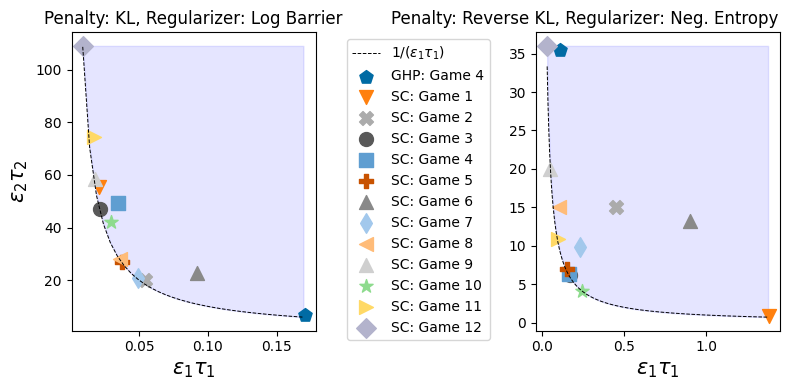

In [22]:
# Plot graph with eps1.tau1 as x-axis and eps2.tau2 as y-axis 
# draw a baseline (1/eps1.tau1) in the plot
# mark the points where (eps2.tau2)>(1/eps1.tau1) for different games

# Game name collection
games = ['GHP: Game 4']
for i in range(1,13):
    games.append('SC: Game '+str(i))


fig = plt.figure(figsize=(8,4)) # Notice the equal aspect ratio
ax_main = [fig.add_subplot(1,2,i+1) for i in range(2)]




# x-y axes collection from above runs
et2 = np.array([110*0.06, 0.555*100, 10*2, 0.837*56, 1.64*30, 2.7*10, 3.8*6,             1.88*11,   2.8*10,   0.65*90, 2.11*20,   2.97*25,   5.74*19])
et1 = np.array([170*0.001, 0.21*0.1, 0.68*0.08, 0.216*0.1, 0.35*0.1, 0.38*0.1, 0.92*0.1, 0.49*0.1, 0.36*0.1, 0.179*0.1, 0.1*0.3, 0.172*0.1, 0.23*0.04])
# print(np.sort(et1)[::-1], np.sort(1/et1))
# plot the graph

ax = ax_main[0]
x = np.sort(et1)[::-1]
# y = np.sort(1/et1)
xx = np.arange(min(et1), max(et1), 0.005)
y = 1/xx
ax.plot(xx, y, color='black', linestyle='--', label=r'$1/(\epsilon_1\tau_1)$', linewidth=0.7)
ax.fill_between(xx, y, et2.max(), color='blue', alpha=.1)
for i in range(13):
    ax.scatter(et1[i], et2[i], color=colors[i], marker=markers[i], label=games[i], s=100)

# ax.legend(loc='upper right')
ax.legend(bbox_to_anchor=(1.1, 1.0))
# ax.grid(visible=True)
ax.set_ylabel(r'$\epsilon_2\tau_2$', fontsize=15)
ax.set_xlabel(r'$\epsilon_1\tau_1$', fontsize=15)
ax.title.set_text('Penalty: KL, Regularizer: Log Barrier') 



# x-y axes collection from above runs
et2 = np.array([355*0.1,   0.9*1,     15*1,   2.8*2.2,   2.9*2.2,   3.5*2,  6*2.2, 3.5*2.8, 6*2.5, 2*10, 4.1*1, 6.4*1.7, 12*3]) 
et1 = np.array([110*0.001, 1.2*1.15, 0.5*0.9, 0.85*0.2, 0.4*0.4, 0.3*0.5, 0.9*1, 1.15*0.2, 0.5*0.2, 0.75*0.067, 0.7*0.35, 0.88*0.11, 0.3*0.1])
# plot the graph
ax = ax_main[1]
x = np.sort(et1)[::-1]
# y = np.sort(1/et1)
xx = np.arange(min(et1), max(et1), 0.005)
y = 1/xx
ax.plot(xx, y, color='black', linestyle='--', label=r'$1/(\epsilon_1\tau_1)$', linewidth=0.7)
ax.fill_between(xx, y, et2.max(), color='blue', alpha=.1)
for i in range(13):
    ax.scatter(et1[i], et2[i], color=colors[i], marker=markers[i], label=games[i], s=100)

# ax.legend(loc='upper left')

# ax.grid(visible=True)
ax.set_xlabel(r'$\epsilon_1\tau_1$', fontsize=15)
ax.set_title('Penalty: Reverse KL, Regularizer: Neg. Entropy',x=0.2)#,y=0.5) 

fig.tight_layout()
# fig.subplots_adjust(wspace=0, hspace=0)